In [307]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats

import eeg

pd.set_option('display.max_rows', 500)

folder_path = "/Users/sim-t/Downloads/archive(2)/SMNI_CMI_TRAIN"
df = eeg.load_all_trials_from_folder(folder_path)


In [311]:
df.columns

idx_list2 = df[((df.matching_condition != 'S1 obj'))].index
#idx_list = df[((df.name == 'co2a0000371'))].index
df = df.drop(idx_list2).reset_index(drop='True').copy()

In [326]:
df.columns

Index(['trial_number', 'sensor_position', 'sample_num', 'sensor_value',
       'subject_identifier', 'matching_condition', 'channel', 'name', 'time'],
      dtype='object')

In [312]:
df.nunique()

trial_number             19
sensor_position          64
sample_num              256
sensor_value          12261
subject_identifier        2
matching_condition        1
channel                  64
name                     16
time                    256
dtype: int64

In [6]:
data_windows = eeg.split_into_windows(df)

In [313]:
def calculate_gfp_with_metadata(data):
    """
    Beregn Global Field Power (GFP) for hvert tidsintervall per trial og inkluder metadata.
    
    Params:
    data (pd.DataFrame): DataFrame med EEG-data. Forventer kolonnene:
    'trial_number', 'time', 'sensor_value', 'subject_identifier', 'name'.
    
    Returns:
    pd.DataFrame: DataFrame med 'trial_number', 'subject_identifier', 'name', 'time' og 'GFP'.
    """
    # Beregn gjennomsnittsverdien for alle sensorer for hvert tidsintervall innen hver trial
    trial_mean = data.groupby(['trial_number', 'time'])['sensor_value'].mean().reset_index()
    trial_mean.columns = ['trial_number', 'time', 'sensor_value_mean']

    # Slå sammen gjennomsnittet med de originale dataene for å legge til gjennomsnittet
    merged_data = data.merge(trial_mean, on=['trial_number', 'time'])

    # Beregn GFP for hvert tidsintervall i hver trial basert på avvik fra gjennomsnittet
    gfp_df = merged_data.groupby(['trial_number', 'time', 'name']).apply(
        lambda x: np.sqrt(np.mean((x['sensor_value'] - x['sensor_value_mean']) ** 2))
    ).reset_index()
    gfp_df.columns = ['trial_number', 'time', 'name', 'GFP']

    # Slå sammen GFP-verdiene med metadataene ('subject_identifier', 'name')
    # Behold én unik rad for hver 'trial_number' og 'time' for å trekke ut metadata
    metadata = data[['trial_number', 'time', 'subject_identifier', 'name']].drop_duplicates()
    

    # Slå sammen GFP-data med metadata
    final_df = gfp_df.merge(metadata, on=['trial_number', 'time', 'name'])

    # Omordne kolonnene slik at de er i ønsket rekkefølge
    final_df = final_df[['trial_number', 'subject_identifier', 'name', 'time', 'GFP']]

    return final_df.reset_index(drop='True')

gfp_df = calculate_gfp_with_metadata(df)
#simple_df = df.groupby(['trial_number', 'subject_identifier', 'name', 'time']).apply(lambda x: np.sqrt(np.mean(df['sensor_value'] - )))
#simple_df.head(5)

C:\Users\sim-t\AppData\Local\Temp\ipykernel_13740\1172584268.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gfp_df = merged_data.groupby(['trial_number', 'time', 'name']).apply(


In [314]:

gfp_df = gfp_df.sort_values(by=['name', 'trial_number'])
gfp_df.columns

Index(['trial_number', 'subject_identifier', 'name', 'time', 'GFP'], dtype='object')

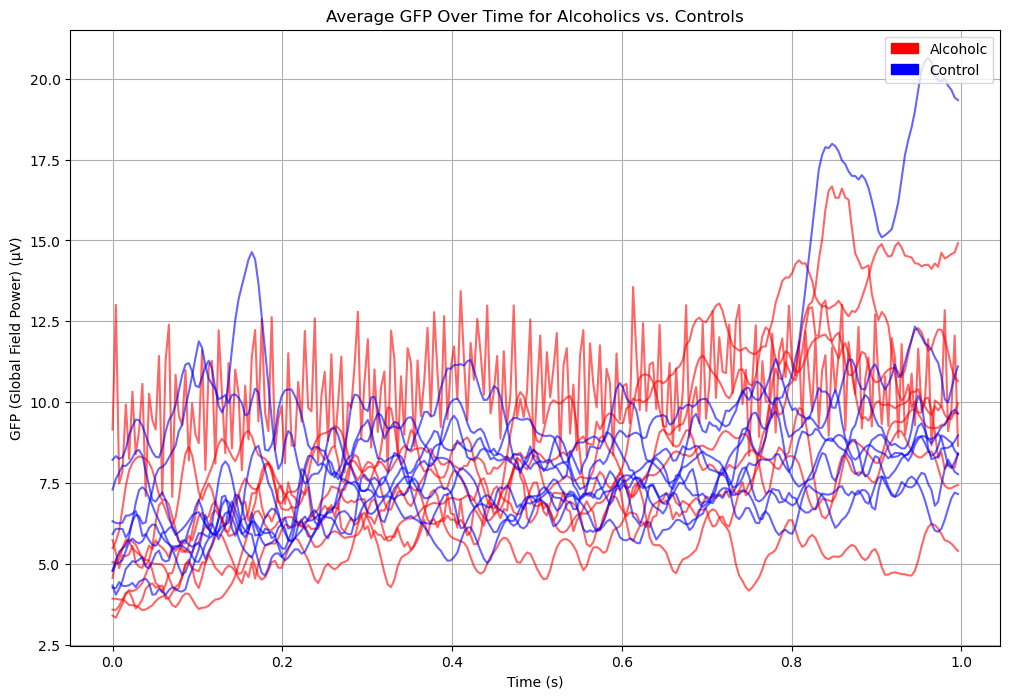

In [315]:
# Hent ut gjennomsnittlig sensorverdi over tid for hver deltaker
gfp_avg_df = gfp_df.groupby(['name', 'time', 'subject_identifier'])['GFP'].mean().reset_index()

# Drops rows with patient co2a0000371, as this patient has unusal readings in comparison to other patiens

#idx_list = gfp_avg_df[((gfp_avg_df.name == 'co2a0000371'))].index
#gfp_avg_df = gfp_avg_df.drop(idx_list)

# Grupper etter deltakernavn og identifikator for visualisering
participants = gfp_avg_df['name'].unique()
plt.figure(figsize=(12, 8))

# Plotte linjer for hver deltaker med farge basert på om de er alkoholikere eller kontrollpersoner
for participant in participants:
    # Filtrer ut data for denne deltakeren
    participant_data = gfp_avg_df[gfp_avg_df['name'] == participant]
    
    # Velg farge basert på identifikatoren
    color = 'red' if participant_data['subject_identifier'].iloc[0] == 'a' else 'blue'
    
    # Plott linjer for hver deltaker
    plt.plot(participant_data['time'], participant_data['GFP'], color=color, alpha=0.6)


# Legg til tittel og etiketter
plt.title('Average GFP Over Time for Alcoholics vs. Controls')
plt.xlabel('Time (s)')
plt.ylabel('GFP (Global Field Power) (µV)')

# Lage legend
a_patch = mpatches.Patch(color = 'red', label = 'Alcoholc')
c_patch = mpatches.Patch(color = 'blue', label = 'Control')
plt.legend(handles=[a_patch, c_patch], loc='upper right')

plt.grid(True)
# Vise grafen
plt.show()

In [316]:
print(gfp_avg_df.columns)
print(gfp_avg_df['name'].unique())
#print(gfp_avg_df.loc[gfp_avg_df['time'] == 0])
print(gfp_avg_df.loc[gfp_avg_df['name'] == 'co2a0000371'].tail())

print(gfp_avg_df.loc[gfp_avg_df['name'] == 'co2a0000372'].tail())

#print(gfp_avg_df.loc[gfp_avg_df['GFP'] == 6.476335])
#print(gfp_avg_df.loc[gfp_avg_df['name'] == 'co2c0000345'])
#print(gfp_avg_df.loc[(gfp_avg_df['name'] == 'co2c0000345') & (gfp_avg_df['GFP'] == 8.600562)])

Index(['name', 'time', 'subject_identifier', 'GFP'], dtype='object')
['co2a0000364' 'co2a0000365' 'co2a0000368' 'co2a0000369' 'co2a0000370'
 'co2a0000371' 'co2a0000372' 'co2a0000375' 'co2c0000337' 'co2c0000338'
 'co2c0000339' 'co2c0000340' 'co2c0000341' 'co2c0000342' 'co2c0000344'
 'co2c0000345']
             name      time subject_identifier        GFP
1531  co2a0000371  0.980469                  a  12.846105
1532  co2a0000371  0.984375                  a   9.104563
1533  co2a0000371  0.988281                  a   9.741814
1534  co2a0000371  0.992188                  a  12.058090
1535  co2a0000371  0.996094                  a   8.656928
             name      time subject_identifier       GFP
1787  co2a0000372  0.980469                  a  9.314509
1788  co2a0000372  0.984375                  a  9.486849
1789  co2a0000372  0.988281                  a  9.636466
1790  co2a0000372  0.992188                  a  9.670555
1791  co2a0000372  0.996094                  a  9.650818


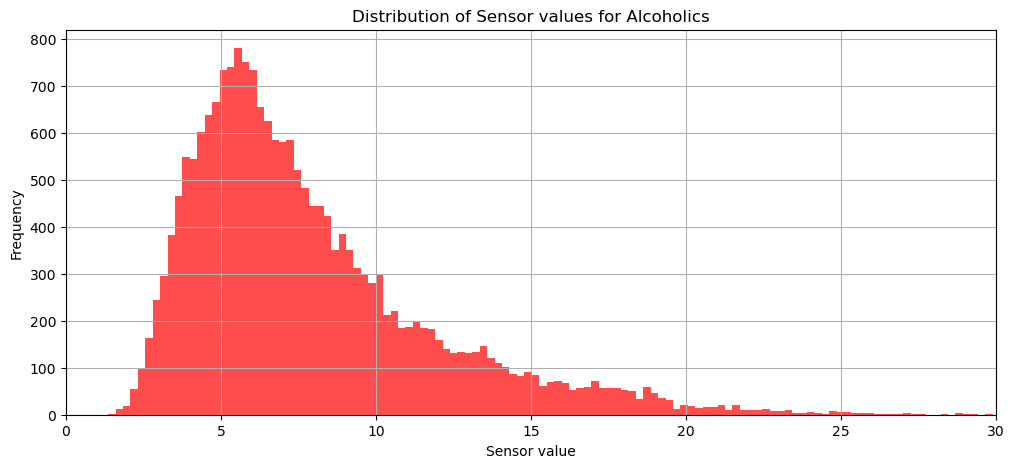

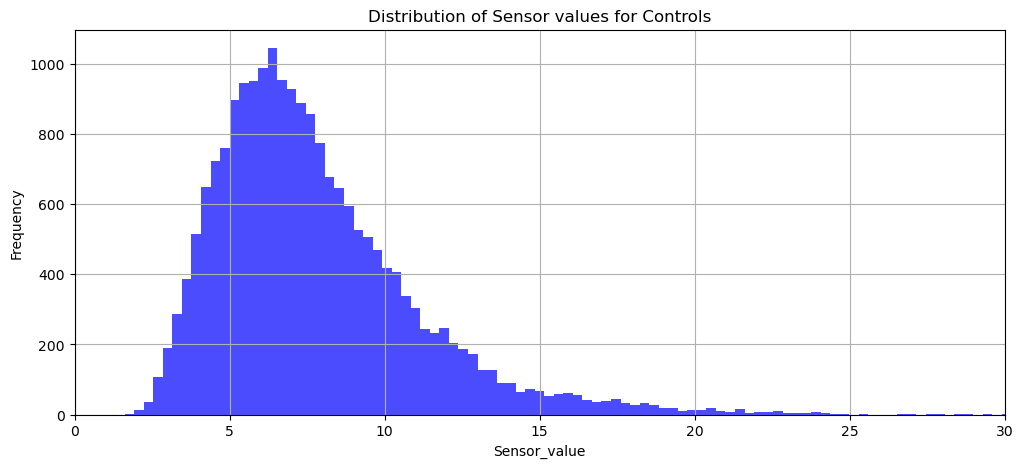

In [317]:
# Del dataene i alkoholikere og kontrollpersoner
alcoholics_data = gfp_df[gfp_df['subject_identifier'] == 'a']
controls_data = gfp_df[gfp_df['subject_identifier'] == 'c']

# Opprett separate figurer for hver gruppe
plt.figure(figsize=(12, 5))
# Histogram for alkoholikere
plt.hist(alcoholics_data['GFP'], bins=300, color='red', alpha=0.7)
plt.title('Distribution of Sensor values for Alcoholics')
plt.xlabel('Sensor value')
plt.ylabel('Frequency')

plt.xlim(0,30)
plt.grid(True)
plt.show()

# Nytt figur for kontrollpersoner
plt.figure(figsize=(12, 5))
plt.hist(controls_data['GFP'], bins=300, color='blue', alpha=0.7)
plt.title('Distribution of Sensor values for Controls')
plt.xlabel('Sensor_value')
plt.ylabel('Frequency')

plt.xlim(0,30)
plt.grid(True)
plt.show()

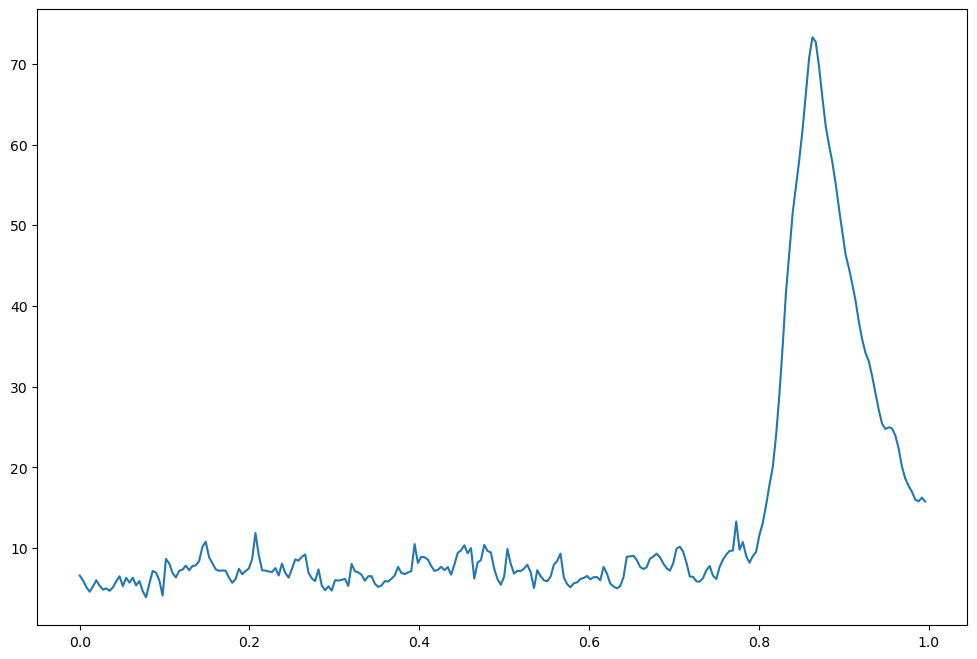

In [323]:
def extract_features(data):
    features = []
    test = 1
    plt.figure(figsize=(12,8))
    plt.plot(data[test]['time'], data[test]['GFP'])

    for window in data:
        window = window.reset_index(drop='True')
        mean = np.mean(window['GFP'])
        variance = np.var(window['GFP'])
        rms = np.sqrt(np.mean(window['GFP']**2))
        skewness = stats.skew(window['GFP'])
        kurtosis = stats.kurtosis(window['GFP'])

        subject_identifier = window.iloc[0, 1]
        features.append([mean, variance, rms, skewness, kurtosis, subject_identifier])

    return pd.DataFrame(features, columns=['Mean', 'Variance', 'RMS', 'Skewness', 'Kurtosis', 'Subject_identifier']).reset_index(drop='True')

features_df = extract_features(eeg.split_into_windows(gfp_df))
#features_df = pd.DataFrame(features, columns=['Mean', 'Variance', 'RMS', 'Skewness', 'Kurtosis', 'Subject_identifier'])



In [325]:
features_df

,Mean,Variance,RMS,Skewness,Kurtosis,Subject_identifier
0,8.146465,5.314276,8.466355,0.237710,-0.706625,a
1,13.297004,218.327573,19.878076,2.543381,5.612903,a
2,11.648224,111.132990,15.710319,2.200698,4.056484,a
3,6.823672,2.989471,7.039316,0.245517,-0.403337,a
4,6.611045,3.062215,6.838723,0.117230,-0.667914,a
5,6.268614,1.746897,6.406436,0.848821,1.346958,a
6,5.357806,1.302771,5.478034,0.540634,0.021878,a
7,6.760322,1.630416,6.879853,0.169068,-0.333565,a
8,5.871112,2.062739,6.044228,0.841005,0.285959,a
9,6.224057,1.792034,6.366390,0.436792,0.289323,a


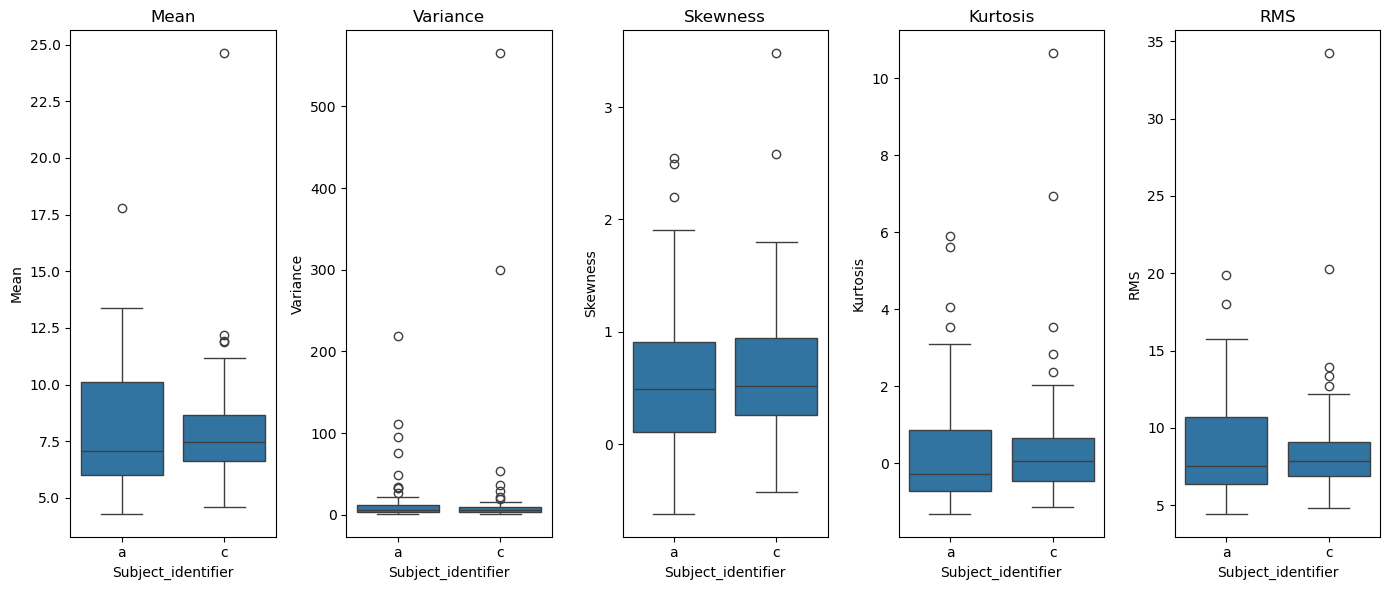

In [320]:
"""Lag boksplotter for alle statistiske funksjoner gruppert etter alkoholiker/kontroll."""
features = ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'RMS']
# Definer plottenes layout
plt.figure(figsize=(14,6))
# Lag boksplott for hver funksjon
for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    sns.boxplot(x=features_df['Subject_identifier'], y = features_df[feature], data=features_df)
    plt.title(feature)

plt.tight_layout()
plt.show()

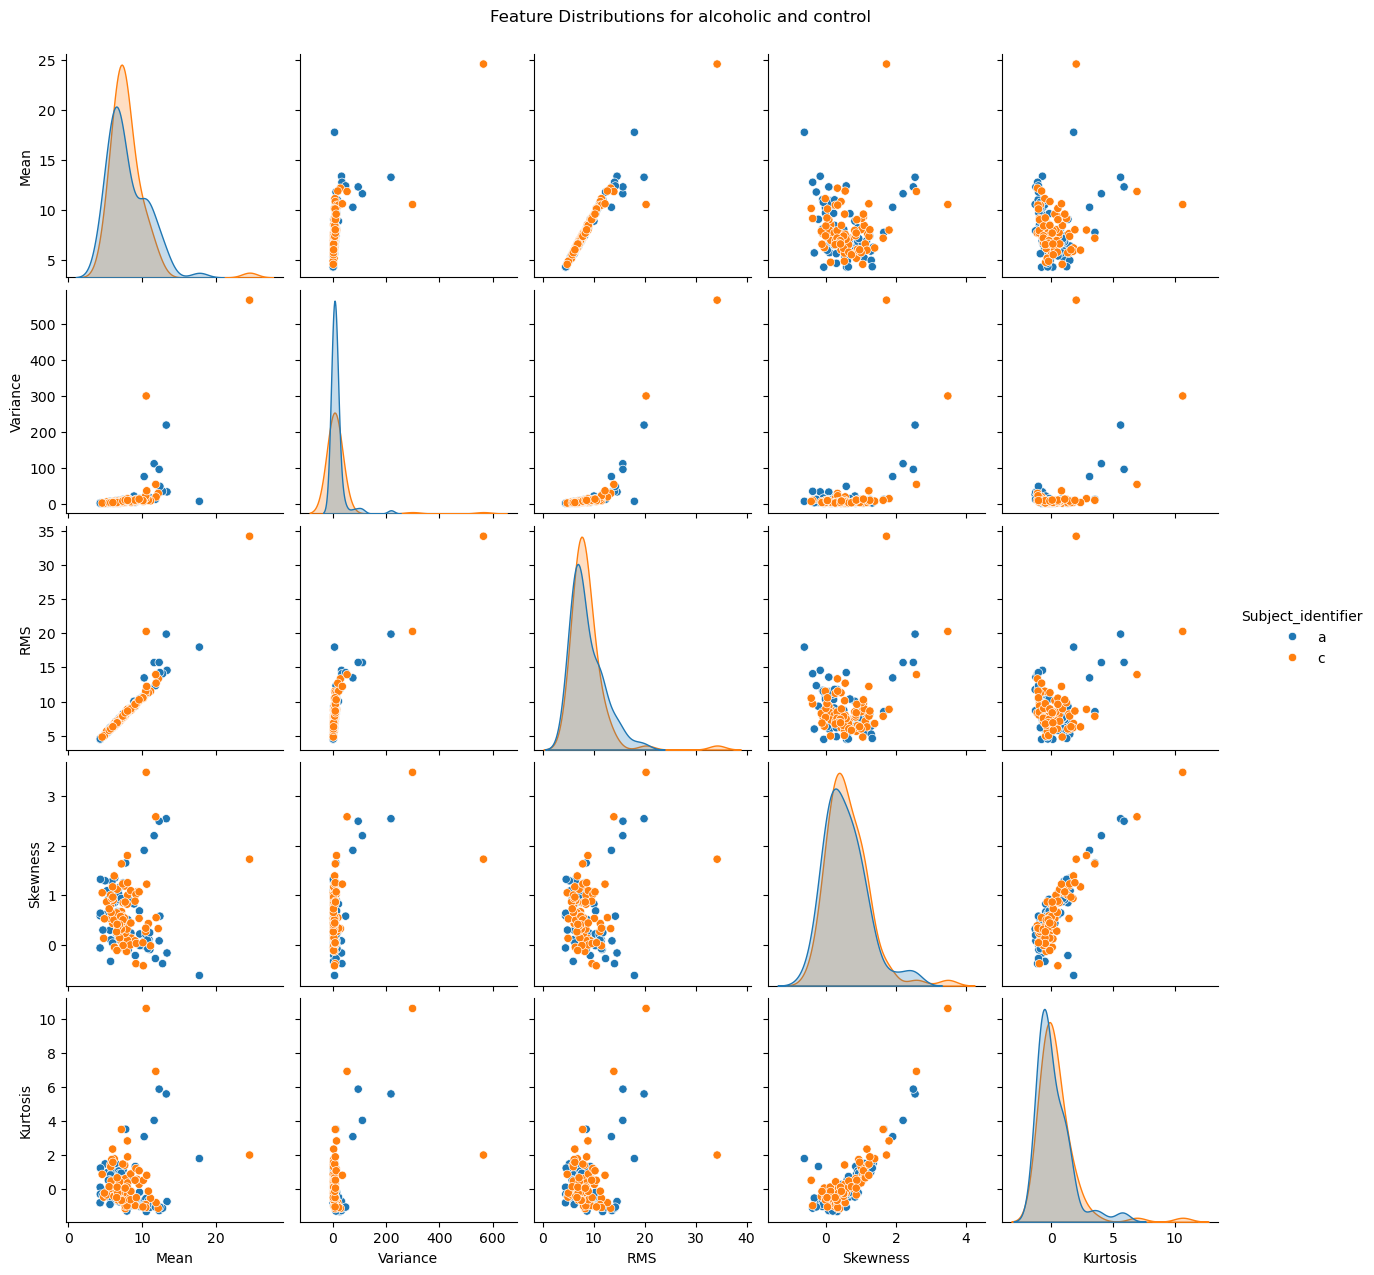

In [321]:
#pairplot_features = feature_data[['mean_amplitude', 'variance', 'rms','subject_identifier']]

sns.pairplot(features_df, hue='Subject_identifier' ,diag_kind='kde')
plt.suptitle('Feature Distributions for alcoholic and control', y=1.02)

plt.show()
